# Running a Recipe Locally
Welcome to the Pangeo Forge introduction tutorial! This is the 2nd part in a sequence, the flow of which is described {doc}`here </introduction_tutorial/index>`.


## Code from Part 1
You'll need the `FilePattern` that was created in Part 1 to work on Part 2.  The Part 1 code is copied here.

In [1]:
import pandas as pd

from pangeo_forge_recipes.patterns import ConcatDim, FilePattern
from pangeo_forge_recipes.recipes import XarrayZarrRecipe

dates = pd.date_range('1981-09-01', '2022-02-01', freq='D')

URL_FORMAT = (
    "https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/"
    "v2.1/access/avhrr/{time:%Y%m}/oisst-avhrr-v02r01.{time:%Y%m%d}.nc"
)

def make_url(time):
    return URL_FORMAT.format(time=time)

time_concat_dim = ConcatDim("time", dates, nitems_per_file=1)
pattern = FilePattern(make_url, time_concat_dim)

## Part 2 Outline

The main goal of the first two parts of this tutorial are to create and run a **recipe**, the object that defines our data transformation. 

In part 2 of this tutorial we wil be using the `FilePattern` we defined in Part 1 to create a recipe and use it to create some cloud optimized data on our own computer!

The steps to doing this are:
1. Create the Recipe object
1. Set up logging
1. Prune the recipe
1. Run the recipe
1. Check output data

Step 1 creates the recipe, steps 2-4 run the recipe, and in step 5 we look at the output of the recipe run. It's all about the recipe. 📃🍰🥧


## Create the Recipe object

While the `FilePattern` object for this dataset took several steps, the [Recipe Class](https://pangeo-forge.readthedocs.io/en/latest/recipe_user_guide/recipes.html) comes pretty quickly. We want to convert our dataset to zarr, so we will use the `XarrayZarrRecipe` class. Implementing the class looks like this:

In [2]:
from pangeo_forge_recipes.recipes import XarrayZarrRecipe

recipe = XarrayZarrRecipe(pattern, inputs_per_chunk=10)
recipe

XarrayZarrRecipe(file_pattern=<FilePattern {'time': 14764}>, storage_config=StorageConfig(target=FSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x7fd6446138e0>, root_path='/tmp/tmpks92q3iz/GF9UMzKP'), cache=CacheFSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x7fd6446138e0>, root_path='/tmp/tmpks92q3iz/71tlenQh'), metadata=MetadataTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x7fd6446138e0>, root_path='/tmp/tmpks92q3iz/uvPTq3sL')), inputs_per_chunk=10, target_chunks={}, cache_inputs=True, copy_input_to_local_file=False, consolidate_zarr=True, consolidate_dimension_coordinates=True, xarray_open_kwargs={}, xarray_concat_kwargs={}, delete_input_encoding=True, process_input=None, process_chunk=None, lock_timeout=None, subset_inputs={}, open_input_with_fsspec_reference=False)

The arguments are:
1. the `FilePattern` object
2. `inputs_per_chunk` - indicates how many files should go into a single chunk of the zarr store. 

Here we choose a value of 10 because each OISST file is ~10MB, resulting approximately 100MB chunks. We can check how big each file is by downloading it from the source URL, explored in Part 1.

In more complex recipes additional arguments may get used, but for this tutorial these two are all we need.

## Set up logging

It's often useful for debugging to turn on logging, which will print additional statements of output while the recipe runs. Logs produce a finer scale update of the downloading, organizing, and converting that happens behind the scenes while a recipe is run.

In [3]:
from pangeo_forge_recipes.recipes import setup_logging

In [4]:
setup_logging()

## Prune the recipe

Currently our recipe is set up to convert over 3 decades worth of data. That is much more data than we need to run a test (and probably more data than fits on our computer). What we want instead is to run a subset of the data, just to make sure the recipe is working. 

Pangeo Forge has a built in function for getting a smaller test-appropriate chunk. The `.copy_pruned()` function duplicates the recipe it is called on and outputs a new recipe object that references just a subset of the data. `.copy_pruned()` is used mainly for testing. 

In [5]:
recipe_pruned = recipe.copy_pruned()

We can see that our new recipe object, `recipe_pruned`, is smaller than the original `recipe` by looking at the `FilePattern` associated with each one. The original `recipe` object has 14,764 time steps, while the new `recipe_pruned` has just two.

In [6]:
recipe.file_pattern

<FilePattern {'time': 14764}>

In [7]:
recipe_pruned.file_pattern

<FilePattern {'time': 2}>

## Run the recipe

The time is here, to run the recipe! There are [multiple ways](https://pangeo-forge.readthedocs.io/en/latest/recipe_user_guide/execution.html) to run the recipe. Here we are going to use the `.to_function()` method to convert our recipe object into a Python function. The output of this method is an actual Python function with the name of the variable you assigned (a function that _creates_ a function!). It can be run like any other function in Python - by using `()`.

In [8]:
run_function = recipe_pruned.to_function()

In [9]:
run_function()

pangeo_forge_recipes.recipes.xarray_zarr - INFO - Caching input 'Index({DimIndex(name='time', index=0, sequence_len=2, operation=<CombineOp.CONCAT: 2>)})'
pangeo_forge_recipes.storage - INFO - Caching file 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc'
pangeo_forge_recipes.storage - INFO - Copying remote file 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc' to cache
pangeo_forge_recipes.recipes.xarray_zarr - INFO - Caching input 'Index({DimIndex(name='time', index=1, sequence_len=2, operation=<CombineOp.CONCAT: 2>)})'
pangeo_forge_recipes.storage - INFO - Caching file 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810902.nc'
pangeo_forge_recipes.storage - INFO - Copying remote file 'https://www.ncei.noaa.gov/data/sea-surface-temperature-op

/mnt/big/envs/envs/kerchunk/lib/python3.8/site-packages/pangeo_forge_recipes/recipes/xarray_zarr.py:111: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  return xr.open_zarr(target.get_mapper())


pangeo_forge_recipes.recipes.xarray_zarr - INFO - Combining inputs for chunk 'Index({DimIndex(name='time', index=0, sequence_len=1, operation=<CombineOp.CONCAT: 2>)})'
pangeo_forge_recipes.recipes.xarray_zarr - INFO - Storing dataset in /tmp/tmpks92q3iz/GF9UMzKP
pangeo_forge_recipes.recipes.xarray_zarr - INFO - Expanding target concat dim 'time' to size 2
pangeo_forge_recipes.recipes.xarray_zarr - INFO - Opening inputs for chunk Index({DimIndex(name='time', index=0, sequence_len=1, operation=<CombineOp.CONCAT: 2>)})
pangeo_forge_recipes.recipes.xarray_zarr - INFO - Opening input with Xarray Index({DimIndex(name='time', index=0, sequence_len=2, operation=<CombineOp.CONCAT: 2>)}): 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc'
pangeo_forge_recipes.storage - INFO - Opening 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.

/mnt/big/envs/envs/kerchunk/lib/python3.8/site-packages/pangeo_forge_recipes/chunk_grid.py:51: UserWarning: chunksize (10) > dimsize (2). Decreasing chunksize to 2
  warnings.warn(


pangeo_forge_recipes.recipes.xarray_zarr - INFO - Storing variable sst chunk Index({DimIndex(name='time', index=0, sequence_len=1, operation=<CombineOp.CONCAT: 2>)}) to Zarr region (slice(0, 2, None), slice(None, None, None), slice(None, None, None), slice(None, None, None))
pangeo_forge_recipes.recipes.xarray_zarr - INFO - Storing variable time chunk Index({DimIndex(name='time', index=0, sequence_len=1, operation=<CombineOp.CONCAT: 2>)}) to Zarr region (slice(0, 2, None),)
pangeo_forge_recipes.recipes.xarray_zarr - INFO - Consolidating dimension coordinate arrays
pangeo_forge_recipes.recipes.xarray_zarr - INFO - Consolidating Zarr metadata


## Check output

Now that the process has run we can use `xarray` to inspect the output data. The `.target_mapper` property of a recipe object tells us where the data is stored. We can use that, along with the `xr.open_zarr()` function of `xarray`, to open up the new dataset.

In [10]:
import xarray as xr

In [11]:
oisst_zarr = xr.open_zarr(recipe.target_mapper, consolidated=True)
oisst_zarr

<xarray.Dataset>
Dimensions:  (time: 2, zlev: 1, lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) datetime64[ns] 1981-09-01T12:00:00 1981-09-02T12:00:00
  * zlev     (zlev) float32 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 dask.array<chunksize=(2, 1, 720, 1440), meta=np.ndarray>
    err      (time, zlev, lat, lon) float32 dask.array<chunksize=(2, 1, 720, 1440), meta=np.ndarray>
    ice      (time, zlev, lat, lon) float32 dask.array<chunksize=(2, 1, 720, 1440), meta=np.ndarray>
    sst      (time, zlev, lat, lon) float32 dask.array<chunksize=(2, 1, 720, 1440), meta=np.ndarray>
Attributes: (12/37)
    Conventions:                CF-1.6, ACDD-1.3
    cdm_data_type:              Grid
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    creator_email:              oisst-help@noaa.gov
    creator_url:                https://www.ncei.noaa.gov/
    date_created:               2020-05-08T19:05:13Z
    ...                         ...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    standard_name_vocabulary:   CF Standard Name Table (v40, 25 January 2017)
    summary:                    NOAAs 1/4-degree Daily Optimum Interpolation ...
    time_coverage_end:          1981-09-01T23:59:59Z
    time_coverage_start:        1981-09-01T00:00:00Z
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...

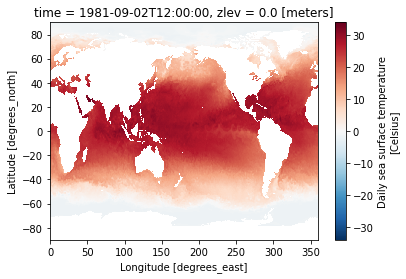

In [12]:
oisst_zarr['sst'].sel(time='1981-09-02').plot()

There it is! Some zarr data that we created during this tutorial! We have converted the netCDF OISST data to zarr and opened it up in xarray. We have a working local recipe.

If we wanted to run the recipe on the full dataset (as opposed to the much smaller pruned version), we would just repeat the above steps on recipe rather than recipe_pruned. This would take a long time, but it would work.

## End of Part 2

In this part of the tutorial we took the `FilePattern` defined in Part 1 and ran it on our local machine to produce some zarr OISST data. We created the recipe, set up logging, pruned the recipe, and ran the recipe with the `.to_function()` method. We then used `xarray` to check the output.

Part 2 completes the features of the `pangeo-forge-recipe` library that we will be looking at in this tutorial sequence. It's important to note - `pangeo-forge-recipes` is a stand alone library that could be run to create ARCO data without utilizing any of the cloud aspects of Pangeo Forge.

Utilizing the cloud is a really powerful aspect of Pangeo Forge, however, so in the next part of the tutorial we will be moving on to how we take our local recipe and get it set up for Pangeo Forge Cloud.

### Code Summary

The code written in part 2 could all be written together as:

In [ ]:
import xarray as xr

from pangeo_forge_recipes.recipes import XarrayZarrRecipe
from pangeo_forge_recipes.recipes import setup_logging

# Create recipe object
recipe = XarrayZarrRecipe(pattern, inputs_per_chunk=2)

# Set up logging
setup_logging()

# Prune the recipe
recipe_pruned = recipe.copy_pruned()

# Run the recipe
run_function = recipe_pruned.to_function()
run_function()

# Check the output
oisst_zarr = xr.open_zarr(recipe.target_mapper, consolidated=True)
oisst_zarr

pangeo_forge_recipes.recipes.xarray_zarr - INFO - Caching input 'Index({DimIndex(name='time', index=0, sequence_len=2, operation=<CombineOp.CONCAT: 2>)})'
pangeo_forge_recipes.storage - INFO - Caching file 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc'
pangeo_forge_recipes.storage - INFO - Copying remote file 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc' to cache
